<a href="https://colab.research.google.com/github/ImAli0/DeepLearning_projects/blob/main/Chest_Disease_Classification/Chest_X_Ray_Classification_Using_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK #1: IMPORT LIBRARIES AND DATASET

In [ ]:
import os
# import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify training data directory
XRay_Directory = '/content/drive/MyDrive/Chest_X_Ray/train'

In [ ]:
# List the folders in the directory
os.listdir(XRay_Directory)

['1', '2', '0', '3']

In [ ]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [ ]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size = 32, directory = XRay_Directory, shuffle
                                                      = True, target_size = (256, 256), class_mode
                                                      = 'categorical', subset = 'training')


Found 428 images belonging to 4 classes.


In [ ]:
validation_generator = image_generator.flow_from_directory(batch_size = 32,
                                                           directory = XRay_Directory,
                                                           shuffle = True,
                                                           target_size = (256,256),
                                                           class_mode = 'categorical',
                                                           subset = "validation")


Found 104 images belonging to 4 classes.


In [ ]:
# Generate a batch of 40 images and labels
!pip install pillow
train_images, train_labels = next(train_generator)


In [ ]:
help(next)

Help on built-in function next in module builtins:

next(...)
    next(iterator[, default])
    
    Return the next item from the iterator. If default is given and the iterator
    is exhausted, it is returned instead of raising StopIteration.



In [ ]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
# labels Translator
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

In [ ]:
print("train_images' shape is ", train_images.shape)
print("\ntrain_labels' shape is ", train_labels.shape)

train_images' shape is  (32, 256, 256, 3)

train_labels' shape is  (32, 4)


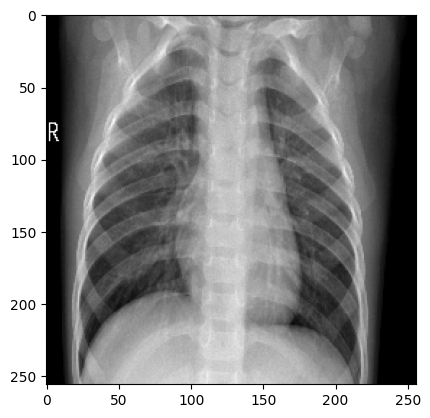

In [ ]:
plt.imshow(train_images[0])

# TASK #2: PERFORM DATA VISUALIZATION

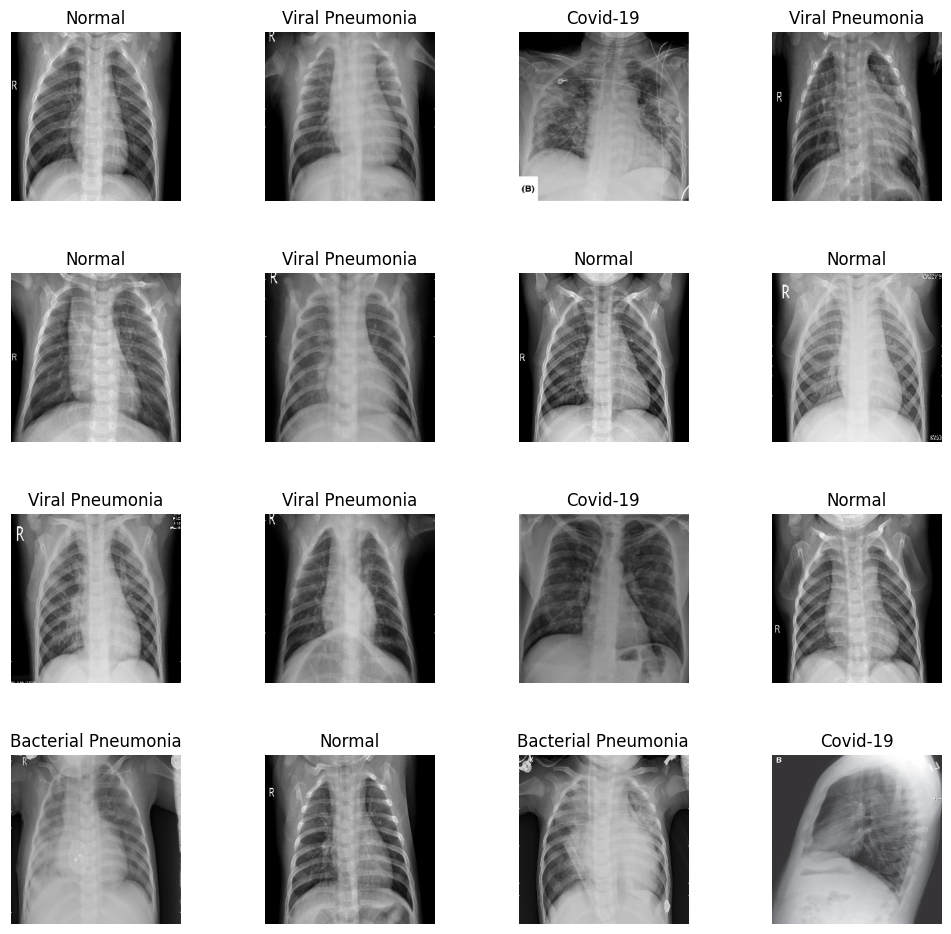

In [ ]:
# Create a grid of 16 images along with their corresponding labels
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

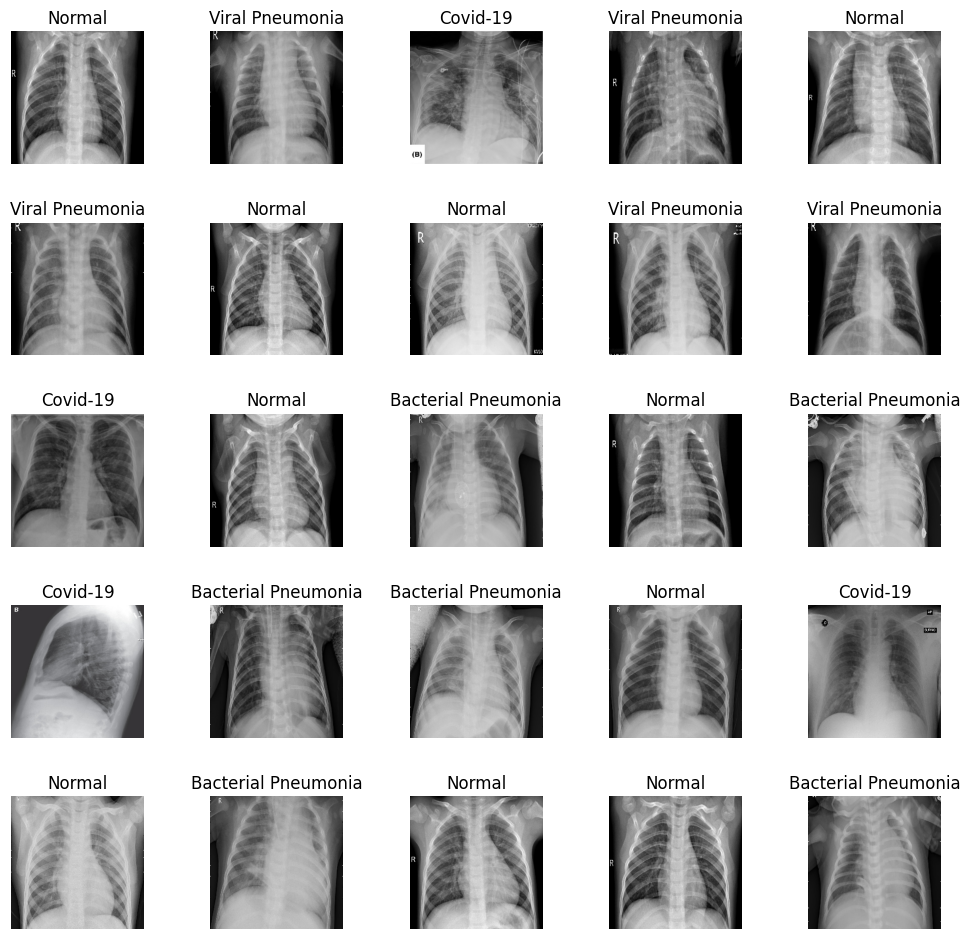

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# TASK #3: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [ ]:
base_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor =
                      Input(shape = (256, 256, 3)))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
# FREEZING
for layer in base_model.layers[:-10]:
  layers.trainable = False

# TASK #4: TRAIN RESNET MODEL WITH THE NEW DATASETS

In [ ]:
head_model = base_model.output
head_model = tf.keras.layers.AveragePooling2D(pool_size = (4, 4))(head_model)
head_model = Flatten(name = 'flatten')(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(128, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)

head_model = Dense(4, activation = 'softmax')(head_model)

model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4, weight_decay=1e-6), metrics= ["accuracy"])

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory,
                       shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory,
                    shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 50,
                    validation_data= val_generator, validation_steps= val_generator.n // 4,
                    callbacks=[checkpointer, earlystopping])

Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 0.9030 - accuracy: 0.6799
Epoch 1: val_loss improved from inf to 5.22115, saving model to weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 51s 140ms/step - loss: 0.9030 - accuracy: 0.6799 - val_loss: 5.2212 - val_accuracy: 0.2500
Epoch 2/50
107/107 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.8388
Epoch 2: val_loss did not improve from 5.22115
107/107 [==============================] - 13s 116ms/step - loss: 0.5193 - accuracy: 0.8388 - val_loss: 12.0957 - val_accuracy: 0.2500
Epoch 3/50
107/107 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.8949
Epoch 3: val_loss did not improve from 5.22115
107/107 [==============================] - 13s 122ms/step - loss: 0.3126 - accuracy: 0.8949 - val_loss: 30.8993 - val_accuracy: 0.2500
Epoch 4/50
107/107 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9579
Epoch 4: val_loss did not improve from 5.22115
107/107 [==============================] - 14s 126ms/step - loss: 0.1629 - accuracy: 0.9579 - val_loss: 21.9370 - val_accuracy: 0.2500
Epoch 5/50
107/107 [============

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("weights.hdf5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model

from tensorflow.keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("weights.hdf5")
print("Loaded model from disk")


Loaded model from disk


# TASK #5: EVALUATE TRAINED DEEP LEARNING MODEL

In [ ]:
# Let's compile the model
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.001, weight_decay = 1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
test_directory = '/content/drive/MyDrive/Chest_X_Ray/Test'


In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True,
                                              target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 40, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


<ipython-input-52-84e114e5cfad>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 40, verbose =1)


1/1 [==============================] - 3s 3s/step - loss: 2.4291 - accuracy: 0.8000
Accuracy Test : 0.800000011920929


In [ ]:
!pip install opencv-python

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 56ms/step


In [ ]:
len(original)

40

In [ ]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.775


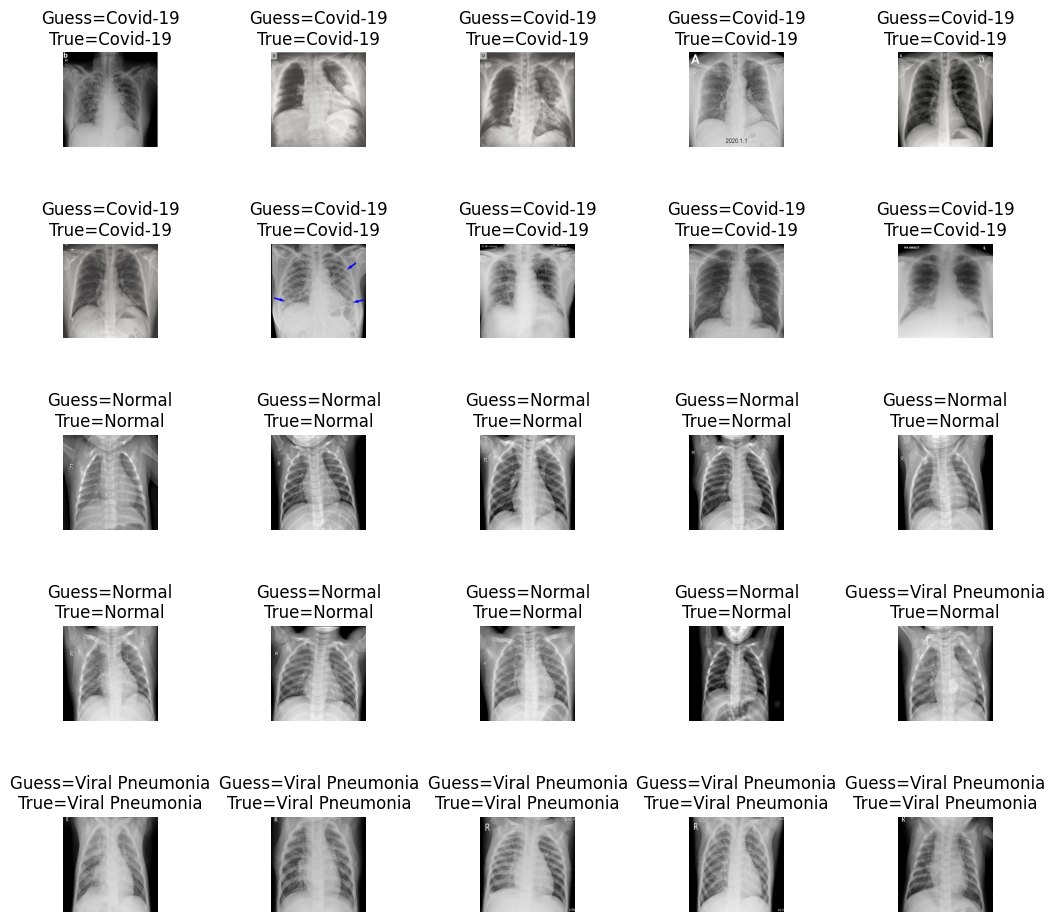

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.82      0.90      0.86        10
           2       0.67      0.60      0.63        10
           3       0.86      0.60      0.71        10

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.77        40



Text(0.5, 1.0, 'Confusion_matrix')

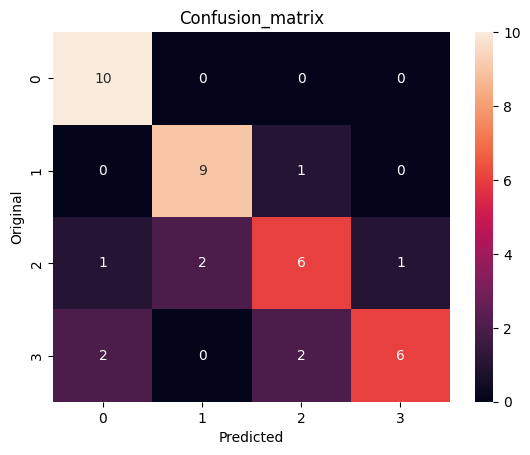

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')